# Final Project

### Collaborators
#### Thomas Martinez,  Jacob Fiola, Katherine Best

**Question of Interest**

The city of Boulder is home to hundreds of trees of varying species. As with any population, some of these trees are in better condition than others.  We aim to investigate what factors most affect the health of Boulder's trees. This has the potential to yield some interesting results what trees do best or worst in Boulder.  For example, are certain types of trees the healthiest?  Or are trees that grow in certain locations the healthiest?  Or does some combination of these factors yield the healthiest trees?

**Dataset**

We will use the 2015 version of the Boulder Public Trees dataset.  This dataset contains information about the location and type of trees in the city of Boulder.  We are using this version instead of the most recent version because it also contains information about the condition of the trees.  The condition takes on one of six values (dead, very poor, poor, fair, good, and excellent) which we will represent as a scale from 1 to 6. This condition column will be the response in any regression we do. For a more complete description of the data, the table from the City of Boulder website describing the data has been attached to the end of this document. 

**Methods Used**

There are a large number of features (39) some of which are redundant or insignificant. Significant features are kept, and insignificant features are then put into PCA to simplify the computational analysis of the data.  We then use multivariate linear regression with the axes obtained from PCA in combination with the significant columns to try to predict the condition of the trees. We then optimize this regression for adjusted r-squared value.  We will split the data into a training set and a testing set and use the training set to build the model.  We will then test the model on the testing set to develop a sense of how accurate the model will be for unseen data. We will also compare this method to traditional feature-selection methods used with MLR.

We initially expected to find that the best indicator of a tree’s condition would be the species of the tree but further analysis suggests that the diseases that the tree has may have the most impact on its overall condition. 


## Data Processing

In [0]:
import numpy as np
import pandas as pd
import math as mt
import statsmodels.api as sm 
import matplotlib.pyplot as plt

In [0]:
##  Run this cell (you might have to run it a couple times) and then select the 
# data from the browser to load it.
# Use the modified version of the data file.
from google.colab import files
uploaded = files.upload()
# try:
#     df = pd.read_csv('Trees_Public.csv')

Saving Trees_Public_Modified.csv to Trees_Public_Modified.csv


In [0]:
import io
df = pd.read_csv(io.BytesIO(uploaded['Trees_Public_Modified.csv']))

In [0]:
# Columns dropped because the fields are unstructured strings 
df = df.drop(columns=['STREET', 'ONSTR', 'FROMSTR', 'TOSTR','SIDE','NOTES']) 

# Columns dropped because all rows (or almost all the rows) in the column have the same value
df = df.drop(columns=['GRATESZ', 'GUARDSZ', 'CULTIVAR'])

# Columns dropped because I dodn't want to deal with them and don't think they would be significant
df = df.drop(columns=['JURISDIC', 'UNIQUEID','INSPECT_DT','INV_DATE', 'INV_TIME','INSPECT_TM'])


df.head()

,XCoord,YCoord,FID,ID,ADDRESS,SUFFIX,SITE,SPP,DBH,CONDITION,INSPECT,MT,MT2,TTYPE,MEMTREE,DISEASEDEF,STRUTDEFEC,LOCTYPE,SITECAT,HOOD,LOCATION,TSIP,ACTIVE,COMMONNAME
0,3.066896e+06,1.255948e+06,0,38718.0,2631,,26,Populus hybrid,3.0,Excellent,N,No Specific Maintenance Need,Routine,Deciduous,No,NaN,NaN,Park,Turf,Park,Elmer's Two Mile,N,1.0,Hybrid Cottonwood
1,3.062702e+06,1.263032e+06,1,43007.0,4501,,33,Ulmus pumila,15.0,Fair,N,Safety Prune,Priority 3,Deciduous,No,NaN,NaN,Park,Natural Area,Park,Violet Park,N,1.0,Siberian Elm
2,3.059594e+06,1.262647e+06,2,38080.0,1001,X,127,Gleditsia triacanthos,4.0,Good,N,No Specific Maintenance Need,Routine,Deciduous,No,NaN,NaN,Park,Turf,Park,Foothills Community Park,N,1.0,Common Honeylocust
3,3.060579e+06,1.245955e+06,3,39118.0,1201,,78,Fraxinus pennsylvanica,31.0,Fair,Y,Safety Prune,Routine,Deciduous,No,NaN,deadwood,Park,Turf,Park,Columbia Cemetery,N,1.0,Green Ash
4,3.068895e+06,1.247883e+06,4,39917.0,1505,,6,Pyrus spp.,3.0,Good,N,No Specific Maintenance Need,Routine,Deciduous,No,NaN,trunk wounds,Park,Shrub /Mulch bed,Park,Scott Carpenter Park,N,1.0,Pear species


In [0]:
# Turning some columns into numeric scales
df['CONDITION'] = df['CONDITION'].replace('Dead',0)
df['CONDITION'] = df['CONDITION'].replace('Very Poor',1)
df['CONDITION'] = df['CONDITION'].replace('Poor',2)
df['CONDITION'] = df['CONDITION'].replace('Fair',3)
df['CONDITION'] = df['CONDITION'].replace('Good',4)
df['CONDITION'] = df['CONDITION'].replace('Excellent',5)

df['MT2'] = df['MT2'].replace('Routine', 0)
df['MT2'] = df['MT2'].replace('Priority 1', 1)
df['MT2'] = df['MT2'].replace('Priority 2', 2)
df['MT2'] = df['MT2'].replace('Priority 3', 3)

df['MEMTREE'] = df['MEMTREE'].replace('No', 0)
df['MEMTREE'] = df['MEMTREE'].replace('Yes', 1)
df['INSPECT'] = df['INSPECT'].replace('N', 0)
df['INSPECT'] = df['INSPECT'].replace('Y', 1)

df['TSIP'] = df['TSIP'].replace('N', 0)
df['TSIP'] = df['TSIP'].replace('Y', 1)

df['SUFFIX'] = df['SUFFIX'].replace(' ', 1)
df['SUFFIX'] = df['SUFFIX'].replace('X', 0)

In [0]:
# Some columns with non-ordinal, but finite ranges can be converted into the combination of a bunch of binary columns
from collections import Counter

def col_expand(df, col_name):
  vals = Counter(df[col_name])
  print(vals)
  for val in vals:
    if not(val is np.nan):
      df[val] = df[col_name]
      df[val] = df[val].replace(val, 1)
      df[val][df[val] != 1] = 0
  df = df.drop(columns=[col_name])
  return df

In [0]:
# Expanding the columns with non-ordinal, finite ranges
df = col_expand(df,'TTYPE')
df = col_expand(df,'SITECAT')
df = col_expand(df,'MT')
df = col_expand(df,'DISEASEDEF')
df['HOOD'] = df['HOOD'].replace('Park', 'Park_nbhd')
df = col_expand(df,'HOOD')
df = col_expand(df,'LOCTYPE')
df = col_expand(df,'LOCATION')
df = col_expand(df,'STRUTDEFEC')
df = col_expand(df,'SPP')
df = col_expand(df,'COMMONNAME')

Counter({'Deciduous': 738, nan: 200, 'Evergreen': 74})
Counter({'Turf': 522, 'Natural Area': 263, 'Shrub /Mulch bed': 157, 'Rock bed': 22, 'Bare dirt': 17, 'Parking Lot Island': 12, 'Raised Planter': 9, 'Pavers / Bricks': 5, 'Tree Grate': 4, 'Open Pit': 1})
Counter({'No Specific Maintenance Need': 621, 'Safety Prune': 254, 'Structure Prune': 44, 'Remove': 37, 'Remove Stakes': 26, 'Treat Pest': 21, 'Other - See Notes': 7, 'Stake': 1, 'REMOVE WHOLE TREE': 1})
Counter({nan: 898, 'other - see notes': 27, 'signs of stress': 22, 'crown dieback': 18, 'needle necrosis': 12, 'foliage disorder': 10, 'borers': 7, 'thin canopy': 5, 'sunscald': 4, 'scale insects': 4, 'hypoxylon canker': 2, 'armillaria': 1, 'cankers': 1, 'sapsucker damage': 1})
Counter({'Park_nbhd': 664, nan: 160, 'Mapleton Hill': 50, 'Northeast Boulder': 45, 'University Hill': 38, 'Whittier': 20, 'Northwest Boulder': 19, 'East Boulder': 4, 'Goss/Grove': 4, 'Iris': 4, 'Northeast Broadway': 2, 'Broadway Southwest': 1, 'Baseline South

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Counter({'Street': 148, 'Wastewater Treatment Plant - 75th': 106, 'Flatirons Golf Course': 62, 'Valmont City Park - Bike Park': 59, 'Park East Park': 57, 'Harlow Platts Park/South Boulder Rec Center': 40, 'PW - Maintenance Transportation Services': 40, 'Columbia Cemetery': 27, 'East Boulder Community Park/Community Center': 25, 'Civic Area - Municipal Complex': 25, 'Foothills Community Park': 24, 'Wonderland Lake Park': 22, 'Civic Area - Boulder Creek Corridor': 20, 'Boulder Reservoir': 18, 'Valmont City Park - South': 16, 'Scott Carpenter Park': 14, 'Eben G Fine Park': 14, 'Maxwell Lake Park': 14, 'Bear Creek Park': 13, 'Martin Park': 13, 'Civic Area - Kids Fishing Ponds': 13, 'Tantra Park': 11, 'Violet Park': 10, "Elmer's Two Mile": 9, 'Elks Park': 9, 'Tom Watson Park': 9, 'Stazio Ballfields': 9, 'Chautauqua Park': 9, 'Eaton Park': 9, 'Wastewater Treatment Plant - Diagonal': 9, 'Crestview  Park': 8, 'Dakota Ridge Park': 8, 'Pearl Street Mall': 7, 'Coot Lake': 6, 'Emma Gomez Martinez 

In [0]:
# Extracting the response to be regressed on
scoreVals = df["CONDITION"]

df = df.drop(columns = ["CONDITION"])

## PCA

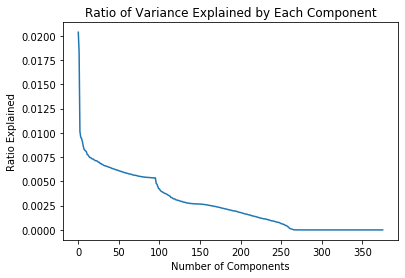

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

A = np.array(df)
A = scale(A)
#print(A.shape)

pca = PCA()
pca.fit(A)
comp = pca.components_

# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('Number of Components')
# plt.ylabel('Variance (%)') 
# plt.show()

plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Ratio Explained') 
plt.title('Ratio of Variance Explained by Each Component');

In [0]:
def my_PCA(A):
  M = np.matmul(A.T, A)
  print('shape M:', M.shape)
  eigvals,eigvecs = np.linalg.eig(M)
  # Construct the matrix E, whose columns are made up of the eigenvectors in order of decreasing strength of their corresponding eigenvalues.
  eigvals_sorted = np.sort(eigvals)
  idx_sorted = np.argsort(eigvals)
  evals,evecs = np.linalg.eig(np.cov(A))
  print(np.argsort(evals).shape)
  E = np.zeros(eigvecs.shape)
  for i in idx_sorted:
    E[i,:] = eigvecs[idx_sorted[i]]
  return E

In [0]:
#### Note that the contents of this cell are preliminary calculations
my_components = my_PCA(A)
#print(my_components - comp)
# evals,evecs = np.linalg.eig(np.cov(A))
# np.argsort(evals)
cov_matrix = np.cov(A)
print('components shape:',pca.components_.shape)
print('covariance matrix shape:', cov_matrix.shape)
eigenval, eigenvec = np.linalg.eig(cov_matrix)
significance = [np.abs(x)/np.sum(eigenval) for x in eigenval]
# plt.figure()
# plt.plot(np.cumsum(significance))
# plt.xlabel('Number of Components')
# plt.ylabel('Variance (%)') #for each component
# plt.show()

shape M: (376, 376)
(1012,)
components shape: (376, 376)
covariance matrix shape: (1012, 1012)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


## Regression

In [0]:

def makeB(numPrincipleComponents):
  B = np.empty((numRows,numPrincipleComponents))
  #B = sm.add_constant(B)

  # produce a "principal tree score" for each tree which uses each of its attributes.
  # These tree scores are just dot products of a Principal component row and a tree row in A. We can choose how many principal components to look at. All principal components orthogonal.
  for x in range(0,len(A)):
    for i in range(0,numPrincipleComponents):
      B[x][i] = np.sum(A[x]*comp[i])
  return B

def regress(A):
  A = sm.add_constant(A)
  #fit the ordinary least-squares model
  model_tree = sm.OLS(scoreVals,A).fit()
  return model_tree


In [0]:
numRows = len(A)

regress(A)
df.columns[46]
#Using MLR, this feature has the largest predictability. Google 'sapsucker damage' for more info.

'sapsucker damage'

In [0]:
#This cell takes a while, you have been warned and so has your cpu.
i = []
rsquares = []
regresses = []
rsquares_adj = []

A = np.array(df)
A = scale(A)
print(A.shape)
numRows = len(A)

for x in range(1,377):
  i.append(x)
  # Now see how the tree scores predict the condition of the trees using MLR
  b = makeB(x)
  reg = regress(b)
  #fit the ordinary least-squares model
  regresses.append(reg)
  rsquares.append(reg.rsquared)
  rsquares_adj.append(reg.rsquared_adj)
  # print(x,reg.rsquared,reg.rsquared_adj)

(1012, 376)
1 0.21956764281514995 0.21879493751100654
2 0.29615693313616387 0.29476180317211265
3 0.3082177298038642 0.306158853999709
4 0.31610418650131944 0.3133876192183058
5 0.3269230938802439 0.3235777812255731
6 0.32834598592404174 0.32433611121314043
7 0.3322965016225162 0.327641198346976
8 0.3330474560371295 0.3277277946695294
9 0.3388533311231733 0.33291488798954916
10 0.33924966623393094 0.33264876379870545
11 0.3394345867599041 0.3321683672142631
12 0.3620483612186045 0.3543852784704796
13 0.3926884473345731 0.3847775754060655
14 0.39277634521149185 0.3842496339105499
15 0.39635364487489577 0.38726258530975866
16 0.39731506080603163 0.38762364469838995
17 0.39914514587401817 0.388868956215928
18 0.406053482222005 0.3952870800870564
19 0.4061479076489548 0.39477372442852154
20 0.40652743327292695 0.3945501867194038
21 0.41053331101555335 0.39802947215830753
22 0.41116830441092656 0.3980699249337176
23 0.41297007905834093 0.399304402761116
24 0.4160762269000291 0.4018774725389

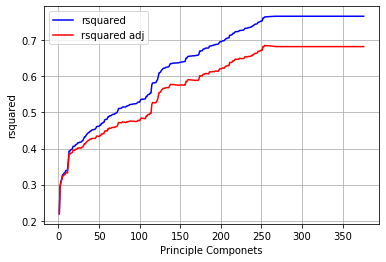

In [0]:
#plot rsquares and adjusted_rsquares
plt.plot(i,rsquares,label='rsquared',color='blue')
plt.plot(i,rsquares_adj,label='rsquared adj',color='red')
plt.xlabel("Principle Componets")
plt.ylabel("rsquared")
plt.legend()
plt.grid(True)

In [0]:
#Find global max of rsquared adjusted
val_r = max(rsquares_adj)
index_r = rsquares_adj.index(val_r)
print("Best Rsquared Adjusted Value:",index_r+1,rsquares_adj[index_r])

Best Rsquared Adjusted Value: 254 0.6856698906814878


## Results 

Currently, every single feature except the response is being fed into PCA. We have plotted the percent of the variance explained by each PCA component and the adjusted r-squared value for each component.  In the plot of the percent of the variance explained by each PCA component we can see that there is a sharp drop off after about 100 components and that after about 250 components the percent of the variance explained by each of the remaining PCA components is very low.  This suggests that we could account for almost all of the variance in the original dataset by using only the first 250 PCA components.  In the plot of the adjusted r-squared value for each component we can see that there is a global maximum at component 254.  So, using more components after this point no longer improves the model more than would be expected from random chance.  Both of these results give us that using about 250 components allows us to account for the vast majority of the variance of the dataset so at the very least, we can produce a regression model with this smaller number of components that we believe will perform as well as if we were to consider the entire dataset.

**Remaining Work**

We will complete the code that performs PCA and compute the explained variance associated with each component and convert the code that performs the regression to use these results.  
 
Then, we will consider some of the attributes of the original dataset that seem to have a high impact on tree health.  For example, in the regression performed on the original dataset (before PCA) we can see that whether or not a tree has spasucker damage has a high impact on its health.  We will remove these attributes from the dataset and perform PCA on the remaining attributes.  We will then do regression on the PCA components and the removed attribute to get a sense of how much that attribute contributes compared to all the other attributes in combination.

